In [16]:
import mne
import pandas as pd
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
import matplotlib.pyplot as plt

def load_epochs_meta(sub_id, run_ids, preprocessed_dir, bands):
    X_all = []
    y_all = []
    meta_all = []
    group_all = []  # for LOSO-CV
    
    for run_id in run_ids:
        run_dir = f'{preprocessed_dir}/{sub_id}_run-{run_id}'
        epo_path = f'{run_dir}/{sub_id}_run-{run_id}_epo.fif'
        meta_path = f'{run_dir}/{sub_id}_run-{run_id}_meta.csv'
        
        # skip missing
        if not os.path.exists(epo_path) or not os.path.exists(meta_path):
            print(f'⚠️ Skipping run {run_id}: files not found.')
            continue
        
        print(f'Loading {sub_id} run {run_id}...')
        
        epochs = mne.read_epochs(epo_path, preload=True)
        epochs.crop(tmin=0.0, tmax=0.5) 
        selected_idx = epochs.selection
        meta_df = pd.read_csv(meta_path)
        meta_df_selected = meta_df.iloc[selected_idx].reset_index(drop=True)

        # === compute PSD ===
        psd = epochs.compute_psd(fmin=1, fmax=50)
        psd_array = psd.get_data()  # shape = (n_epochs, n_channels, n_freqs)
        freqs = psd.freqs  # shape = (n_freqs,)

        # === 只保留 alpha / beta band power ===
        X_run = []
        for band_name, (fmin, fmax) in bands.items():
            band_mask = (freqs >= fmin) & (freqs <= fmax)
            band_power = psd_array[:, :, band_mask].mean(axis=2)
            X_run.append(band_power)
        
        X_run = np.concatenate(X_run, axis=1)  # (n_epochs, n_channels * n_bands)
        y_run = meta_df_selected['pos'].map({'NN': 0, 'VV': 1}).to_numpy()
        
        # collect → 也應該 append 對齊後的 meta_df
        X_all.append(X_run)
        y_all.append(y_run)
        meta_all.append(meta_df_selected)
        group_all.append(np.ones(len(y_run)) * run_id)

    
    # concat
    if len(X_all) == 0:
        raise ValueError("❌ No valid data loaded!")
    
    X = np.concatenate(X_all, axis=0)
    y = np.concatenate(y_all, axis=0)
    meta_df_all = pd.concat(meta_all, ignore_index=True)
    groups = np.concatenate(group_all, axis=0)
    
    print(f'\n✅ Loaded data: X shape {X.shape}, y shape {y.shape}')
    print(f'Number of NN: {(y==0).sum()}, VV: {(y==1).sum()}')
    return X, y, meta_df_all, groups, epochs.info  # info for topo plot

def run_loso_svm(X, y, groups, use_balanced=True):
    if use_balanced:
        clf = SVC(kernel='linear', class_weight='balanced')
    else:
        clf = SVC(kernel='linear')
    
    logo = LeaveOneGroupOut()
    
    scores = cross_val_score(clf, X, y, cv=logo.split(X, y, groups))
    
    print(f'\nLOSO-CV accuracy (balanced={use_balanced}): {scores.mean():.2f} ± {scores.std():.2f}')
    print(f'Per run accuracy: {scores}')

    # fit once for weight plot
    clf.fit(X, y)
    coefs = clf.coef_.flatten()
    return coefs


In [17]:
# === Example usage ===

# 設定 subject / run / band
sub_list = ['sub-01']  # 你也可以給 ['sub-01', 'sub-02', ...] 一次處理多 subject
run_ids = list(range(1, 60))  # or smaller list for testing
preprocessed_dir = 'PreprocessedEpochs'

bands = {
    'full':(1,40),
    #'Alpha': (8, 12),
    #'Beta': (13, 30)
}

# 只跑一個 subject
for sub_id in sub_list:
    print(f'\n=== Running {sub_id} ===\n')
    
    # 1️⃣ load data
    X, y, meta_df_all, groups, info = load_epochs_meta(sub_id, run_ids, preprocessed_dir, bands)
    
    # 2️⃣ run LOSO-CV SVM
    # Balanced SVM
    coefs = run_loso_svm(X, y, groups, use_balanced=True)

    # 不加 balanced
    #coefs = run_loso_svm(X, y, groups, use_balanced=False)

    
    # 3️⃣ plot weights
    # plot_svm_weights(coefs, info, bands)


=== Running sub-01 ===

Loading sub-01 run 1...
Reading /Users/meguser/Desktop/Project for Brainhack/domybest/PreprocessedEpochs/sub-01_run-1/sub-01_run-1_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
391 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Loading sub-01 run 2...
Reading /Users/meguser/Desktop/Project for Brainhack/domybest/PreprocessedEpochs/sub-01_run-2/sub-01_run-2_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
371 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Loading sub-01 run 3...
Reading /Users/meguser/Desktop/Project for Brainhack/domybest/PreprocessedEpochs/sub-01_run

In [18]:
def plot_svm_weights(coefs, info, bands):
    """
    Plot SVM weights as topomap → grad only → auto reshape → auto print summary
    """
    n_channels_total = len(info['chs'])
    n_bands = len(bands)
    
    # Reshape coefs
    coefs_per_band = coefs.reshape(n_bands, n_channels_total)
    
    # Pick grad channels
    picks_grad = mne.pick_types(info, meg='grad')
    info_grad = mne.pick_info(info, sel=picks_grad)
    
    # Reshape coefs per band per grad
    coefs_grad_per_band = coefs_per_band[:, picks_grad]
    
    print('\n=== SVM weight summary ===')
    
    for i, (band_name, _) in enumerate(bands.items()):
        band_weights = coefs_grad_per_band[i]
        mean_w = band_weights.mean()
        std_w = band_weights.std()
        max_w = band_weights.max()
        min_w = band_weights.min()
        
        print(f'{band_name} band → mean weight: {mean_w:.4f}, std: {std_w:.4f}, max: {max_w:.4f}, min: {min_w:.4f}')
        
        # Plot topomap
        mne.viz.plot_topomap(band_weights, info_grad, show=True, contours=0)
        plt.title(f'SVM weights: {band_name} band (grad)')



=== SVM weight summary ===
full band → mean weight: 0.0000, std: 0.0000, max: 0.0000, min: -0.0000


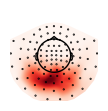

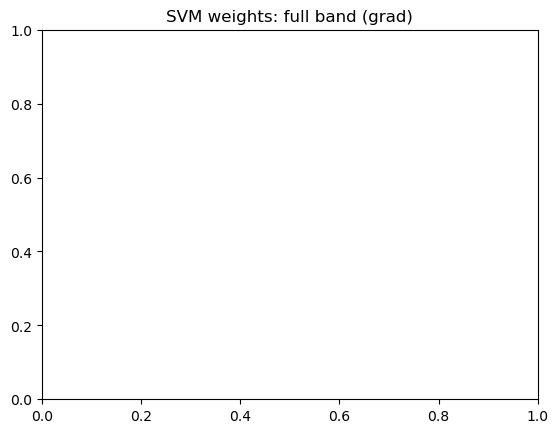

In [19]:
plot_svm_weights(coefs, info, bands)

In [26]:
# === Example usage ===

# 設定 subject / run / band
sub_list = ['sub-01']  # 你也可以給 ['sub-01', 'sub-02', ...] 一次處理多 subject
run_ids = list(range(1, 12))  # or smaller list for testing
preprocessed_dir = 'PreprocessedEpochs'

bands = {
    'Alpha': (8, 12),
    'Beta': (13, 30)
}

# 只跑一個 subject
for sub_id in sub_list:
    print(f'\n=== Running {sub_id} ===\n')
    
    # 1️⃣ load data
    X, y, meta_df_all, groups, info = load_epochs_meta(sub_id, run_ids, preprocessed_dir, bands)
    
    # 2️⃣ run LOSO-CV SVM
    # Balanced SVM
    coefs = run_loso_svm(X, y, groups, use_balanced=True)

    # 不加 balanced
    #coefs = run_loso_svm(X, y, groups, use_balanced=False)

    
    # 3️⃣ plot weights
    # plot_svm_weights(coefs, info, bands)


=== Running sub-01 ===

Loading sub-01 run 1...
Reading /Users/meguser/Desktop/Project for Brainhack/domybest/PreprocessedEpochs/sub-01_run-1/sub-01_run-1_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
391 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Loading sub-01 run 2...
Reading /Users/meguser/Desktop/Project for Brainhack/domybest/PreprocessedEpochs/sub-01_run-2/sub-01_run-2_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
371 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Loading sub-01 run 3...
Reading /Users/meguser/Desktop/Project for Brainhack/domybest/PreprocessedEpochs/sub-01_run

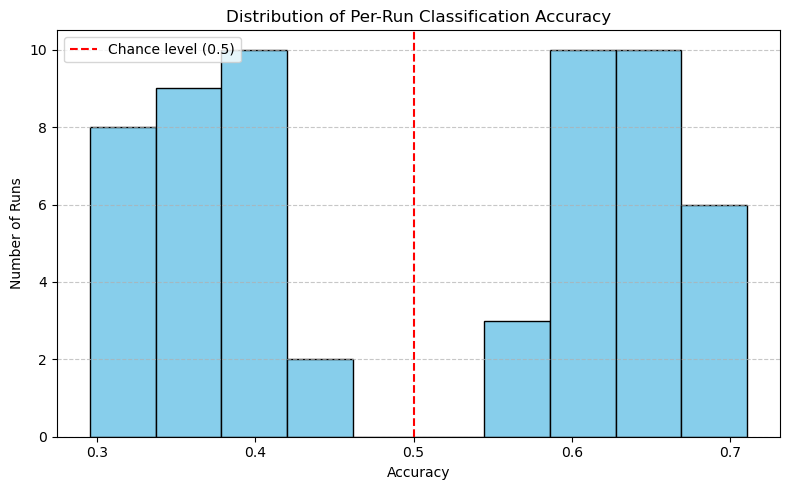

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Input accuracy values
accuracy_values = np.array([
    0.59590793, 0.41239892, 0.35443038, 0.59413203, 0.67559524, 0.36085627,
    0.58858859, 0.37951807, 0.61818182, 0.64983165, 0.38369305, 0.67356322,
    0.68539326, 0.3253012, 0.4056338, 0.45348837, 0.5738255, 0.5887574,
    0.4, 0.63480392, 0.41242938, 0.32601881, 0.39295393, 0.38170347,
    0.64482759, 0.66233766, 0.68852459, 0.57843137, 0.29545455, 0.30350195,
    0.62532982, 0.64588529, 0.30870712, 0.60613811, 0.35962145, 0.40625,
    0.34242424, 0.62912088, 0.30666667, 0.33481153, 0.58333333, 0.35519126,
    0.60057471, 0.65337423, 0.37393768, 0.33136095, 0.61142857, 0.6870229,
    0.43425076, 0.63355408, 0.62533693, 0.71078431, 0.3648294, 0.38860104,
    0.6601467, 0.6408046, 0.36513158, 0.36050157
])

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(accuracy_values, bins=10, edgecolor='black', color='skyblue')
plt.axvline(x=0.5, color='red', linestyle='--', label='Chance level (0.5)')
plt.title('Distribution of Per-Run Classification Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Number of Runs')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


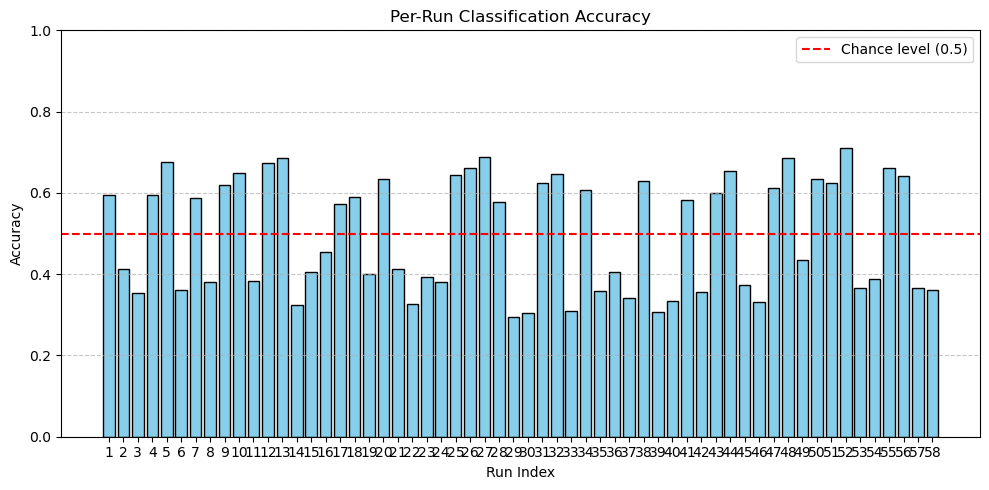

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Input accuracy values
accuracy_values = np.array([
    0.59590793, 0.41239892, 0.35443038, 0.59413203, 0.67559524, 0.36085627,
    0.58858859, 0.37951807, 0.61818182, 0.64983165, 0.38369305, 0.67356322,
    0.68539326, 0.3253012, 0.4056338, 0.45348837, 0.5738255, 0.5887574,
    0.4, 0.63480392, 0.41242938, 0.32601881, 0.39295393, 0.38170347,
    0.64482759, 0.66233766, 0.68852459, 0.57843137, 0.29545455, 0.30350195,
    0.62532982, 0.64588529, 0.30870712, 0.60613811, 0.35962145, 0.40625,
    0.34242424, 0.62912088, 0.30666667, 0.33481153, 0.58333333, 0.35519126,
    0.60057471, 0.65337423, 0.37393768, 0.33136095, 0.61142857, 0.6870229,
    0.43425076, 0.63355408, 0.62533693, 0.71078431, 0.3648294, 0.38860104,
    0.6601467, 0.6408046, 0.36513158, 0.36050157
])

# X 軸：run index (1-based)
run_indices = np.arange(1, len(accuracy_values) + 1)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(run_indices, accuracy_values, color='skyblue', edgecolor='black')
plt.axhline(y=0.5, color='red', linestyle='--', label='Chance level (0.5)')
plt.title('Per-Run Classification Accuracy')
plt.xlabel('Run Index')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)  # 固定 y 軸範圍到 1.0
plt.xticks(run_indices)  # 顯示所有 run index
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save figure
plt.savefig('per_run_accuracy.png', dpi=300)  # 儲存圖片，高解析度
plt.show()
